In [1]:
from tkinter import *
import numpy as np
import time
import math
import matplotlib.pyplot as plt

tk = Tk()
tk.title('shepherd')
tk.wm_attributes("-topmost", 1)
Width = 600
Height = 600
canvas = Canvas(tk, width=Width, height=Height, bg='white', highlightthickness=0)
canvas.pack()
canvas.create_line(Width / 2, 0, Width / 2, Height)
canvas.create_line(0, Height / 2, Height, Height / 2)
canvas.create_line(Height - 150, Height - 150, Height - 150, Height, Height - 150, Height - 150, Height, Height - 150)
tk.update()

N = 50
Ra = 6
speed = 5
speeds = 1.5 * speed
Rs = 250

class Agent:
    def __init__(self, x, y, u, v, color):
        self.canvas = canvas
        self.color = color
        self.id = self.canvas.create_oval(x, y, u, v, fill=self.color)
        self.x = np.random.uniform(-1, 1)
        self.y = np.random.uniform(-1, 1)
        self.canvas_height = self.canvas.winfo_height()
        self.canvas_width = self.canvas.winfo_width()
        self.tag = True

    def position(self):
        """"返回目标当前的位置"""
        pos = self.canvas.coords(self.id)
        return pos

    def draw(self):
        """绘制目标对象的运动状态"""
        if self.tag:
            pos = self.canvas.coords(self.id)
            if pos[0] <= 0:
                self.x = 10
            if pos[1] <= 0:
                self.y = 10
            if pos[2] > self.canvas_width:
                self.x = -10
            if pos[3] > self.canvas_height:
                self.y = -10
        else:
            self.x = 0
            self.y = 0
        self.canvas.move(self.id, self.x, self.y)

    def position2point(self):
        """把目标的两个坐标转换为中心的一个坐标"""
        pos = self.position()
        point = [0.0, 0.0]
        point[0] = (pos[0] + pos[2]) / 2
        point[1] = (pos[1] + pos[3]) / 2
        return np.array(point)

    def delete(self):
        """删除目标对象"""
        self.canvas.delete(self.id)

    def stop(self):
        """当目标对象到达指定区域则停止运动"""
        self.tag = False


def sheeps_move(herd, array):
    """羊根据牧羊犬的位置的移动情况,如果两者之间的距离大于100米，则羊只进行简单的随机运动，否则牧羊犬会受到五个不同方向的线性合力"""
    n = len(array)
    last = np.zeros((n, 2), dtype=np.float32)
    for i in range(n):
        point = agent['sheep' + str(i)].position2point()
        ps_dist = np.linalg.norm(point - herd)
        l_mean, ra = knn(point, array, k)
        if ps_dist > Rs:
            H = np.random.uniform(-1, 1, size=2)  # H为-1到1随机运动的大小
            H = H / np.linalg.norm(H)  # 把数据归一化
            last[i] = H
        else:
            rs = (point - herd) / ps_dist
            C = (l_mean - point) / np.linalg.norm(l_mean - point)
            e = np.random.uniform(-1, 1, size=2)
            H = 0.5 * last[i] + 1.05 * C + rs + 2 * 1.0*ra + 0.3 * e/np.linalg.norm(e)    
            H = H / np.linalg.norm(H)
            last[i] = H
            H = H * speed
        agent['sheep' + str(i)].x = H[0]
        agent['sheep' + str(i)].y = H[1]
        agent['sheep' + str(i)].draw()
        array[i] = last[i] + point
    
def driving(herd, target, array, g_mean):
    """把羊往目标点驱赶"""
    sheeps_move(herd, array)
    gt_dist = np.linalg.norm(target - g_mean)
    Pd = (g_mean - target) / gt_dist * Ra * math.sqrt(N) + g_mean
    rd = (Pd - herd) / np.linalg.norm(Pd - herd) * speeds
    shepherd.x = rd[0]
    shepherd.y = rd[1]
    rd = rd + herd
    g_mean = np.array([np.mean(array[:, 0]), np.mean(array[:, 1])])
    shepherd.draw()
    return array, g_mean, rd


def collecting(herd, array, g_mean):
    """把远离中心的羊聚集起来"""
    far = find_farest(array, g_mean)
    sheeps_move(herd, array)
    gt_dist = np.linalg.norm(far - g_mean)
    pc = (far - g_mean) / gt_dist * Ra  + far
    rd = (pc - herd) / np.linalg.norm(pc - herd) * speeds
    shepherd.x = rd[0]
    shepherd.y = rd[1]
    rd = rd + herd
    g_mean = np.array([np.mean(array[:, 0]), np.mean(array[:, 1])])
    shepherd.draw()
    return array, g_mean, rd


def knn(x, others, k): # 用在sheeps_move这个函数中
    """根据给出的坐标，计算出与该坐标最近的k个点,并返回局部中心点和羊内部作用力的合力方向"""
    d = [np.linalg.norm(x - x_) for x_ in others]
    near = np.argsort(d)
    top = [others[v] for v in near[1:k + 1]]
    t = np.array(top)
    local_m = [np.mean(t[:, 0]), np.mean(t[:, 1])]
    local_m = np.array(local_m, np.float32)
    ra = np.zeros(2, dtype=np.float32)
    for p in near[1:k + 1]:
        if d[p] <= Ra:
            ra += (x - others[p]) / np.linalg.norm(x - others[p])
    return local_m, ra


def check(lst, g_mean):
    """对所有的羊检查是否都在全局中心点的Fn半径范围内"""
    d = [np.linalg.norm(x - g_mean) for x in lst]
    D = np.array(d)
    return np.all(D <= Fn)


def find_farest(arrv, g_m):
    """找到离中心最远的羊"""
    d = [np.linalg.norm(x - g_m) for x in arrv]
    near = np.argsort(d)
    return arrv[near[-1]]


def all_sheeps_in(arrx):
    """判断是否所有羊都到达了目标区域"""
    for p in arrx:
        if p[0] < Height - 145 or p[1] < Height - 145:
            return False
    return True


"""初始化的羊群"""
colors = ['black', 'green', 'blue', 'yellow', 'orange', 'pink', 'purple']
target = np.array([Height - 40, Height - 40])
UU = []
VV = []
XX = []
YY = []
# 遍历统计每个规模下的运动时长 
X = []
Px = {}
Py = {}
for i in range(N):
    Px['coor'+str(i)] = []
    Py['coor'+str(i)] = []

k = N // 2 + 5
Fn = Ra * math.sqrt(N)
last = np.zeros((N, 2), dtype=np.float32)  # 惯性方向，是个标准化的向量
agent = {}
for i in range(N):
    np.random.seed(i)
    x = np.random.randint(50, 500)
    y = np.random.randint(50, 500)
    X.append([x, y])
    agent['sheep' + str(i)] = Agent(x - Ra/2, y - Ra/2, x + Ra/2, y + Ra/2, colors[1])
X = np.array(X)
shepherd = Agent(560, 560, 560 + Ra, 560 + Ra, 'red')
shepherd_point = shepherd.position2point()
global_mean = np.array([np.mean(X[:, 0]), np.mean(X[:, 1])])
for i in range(N):
    Px['coor'+str(i)].append(X[i][0]) 
    Py['coor'+str(i)].append(X[i][1]) 


step = 0
while True:
    if check(X, global_mean):
        X, global_mean, shepherd_point = driving(shepherd_point, target, X, global_mean)
    else:
        X, global_mean, shepherd_point, = collecting(shepherd_point, X, global_mean)
    if all_sheeps_in(X) or step > 8000:
        break
    for i in range(N):
        Px['coor'+str(i)].append(X[i][0]) 
        Py['coor'+str(i)].append(X[i][1]) 
    XX.append(shepherd_point[0])
    YY.append(shepherd_point[1])
    UU.append(global_mean[0])
    VV.append(global_mean[1])
    tk.update()
    time.sleep(0.01)
    step += 1
print(step)  
"""游戏结束"""
label = Label(tk, text="游戏结束!", font=('楷体', 40), fg='red')
label.place(x=175, y=285)
tk.mainloop()


228


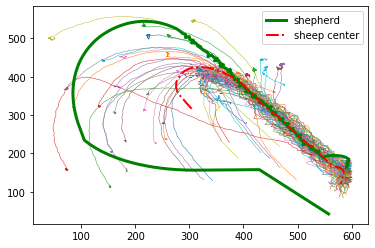

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

xx = np.array(XX)
yy = np.array(YY)
uu = np.array(UU)
vv = np.array(VV)

for i in range(N):
   plt.plot(np.array(Px['coor'+str(i)]), 600-np.array(Py['coor'+str(i)]), linewidth=0.5)

plt.plot(xx, 600-yy,'g',label='shepherd',linewidth=3)
plt.plot(uu, 600-vv,'r-.',label='sheep center',linewidth=2)
plt.legend()
plt.show()
fig.savefig('oldtrial.pdf',dpi=600,format='pdf')

In [6]:
import math
n = len(uu)
dist1 = 0
for i in range(1, n):
    dist1 += math.sqrt((uu[i]-uu[i-1])**2 + (vv[i] - vv[i-1])**2 )
dist2 = 0
for i in range(1, n):
    dist2 += math.sqrt((xx[i]-xx[i-1])**2 + (yy[i] - yy[i-1])**2 )
print(dist1)
print(dist2)

567.461249591922
1702.5
